Устанавливаем необходимые библиотеку в систему. Тестирование проводилось в среде Yandex Datasphere, поэтому устанавливались не все библиотеки, а только недостающие. 

In [1]:
# %pip install datasets transformers qwen_vl_utils

In [2]:
# %pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
# %pip install accelerate

Подключаем библиотеки

In [3]:
import argparse
import json
import os
import time
from pathlib import Path

from typing import List, Dict, Tuple, Optional

import torch
from torch import nn
from tqdm.auto import tqdm

from datasets import load_dataset, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import (
    AutoProcessor,
    AutoModelForCausalLM,
    AutoTokenizer,
)

from transformers import Qwen2_5_VLForConditionalGeneration

from qwen_vl_utils import process_vision_info

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-07-07 18:43:53.573535: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 18:43:53.620292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 18:43:54.465372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Функции-утилиты для работы с файлами

In [4]:
def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def timestamp() -> str:
    return time.strftime("%Y%m%d_%H%M%S", time.localtime())

Функция для создания датасета на основе набора фотографий глазного дна

In [5]:
def get_dataset(root_dir="/home/jupyter/datasphere/project/data", target_size=(1026, 684)) -> Dataset:
    records = []
    
    root_dir = Path(root_dir)
    
    for file_name in os.listdir(root_dir):
        file_path = root_dir / file_name
        if file_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]:
            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(target_size, Image.BILINEAR)
                records.append({"image": img})
            except Exception as e:
                print(f"Не удалось открыть {file_path}: {e}")

    return Dataset.from_list(records)

Функция для визуализации изменения вероятности набора токенов по слоям модели

In [6]:
def plot_token_trajectory(result: Dict, save_path: Path, title: Optional[str] = None):
    """Line plot of top‑k token probabilities across layers."""

    topk_probs = result["topk_probs"]  # (L+1) × k
    tokens = result["topk_tokens"]
    layers = list(range(topk_probs.shape[0]))

    plt.figure(figsize=(10, 4))
    for i in range(topk_probs.shape[1]):
        prob_series = topk_probs[:, i]
        token_label = tokens[-1][i]  # final layer’s rank‑i token as label
        plt.plot(layers, prob_series, label=token_label)

    plt.xlabel("Layer index")
    plt.ylabel("Probability at last position")
    plt.title(title or "Token probability trajectories")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()

Основной модуль, реализующий подход logit lens 

In [7]:
class LogitLensMultimodal:
    def __init__(
        self,
        model: Qwen2_5_VLForConditionalGeneration,
        model_name: str,
        dtype: torch.dtype = torch.float16,
        device: str | torch.device = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """Loads model + processor & tokenizer for vision‑language probing."""

        self.model = model.eval()

        self.device = device

        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, trust_remote_code=True
        )
        self.processor = AutoProcessor.from_pretrained(
            model_name, trust_remote_code=True, use_fast=True
        )

        self.lm_head = self.model.get_output_embeddings()

    @torch.inference_mode()
    def run_sample(
        self,
        image: Image.Image,
        prompt: str,
        top_k: int = 5,
    ) -> Dict:
        """Forward a single (image, prompt) pair & collect layer diagnostics."""

        # Создаем входное сообщение, используя пример из репозитория модели Qwen2.5-VL
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": prompt},
                ],
            }
        ]
        
        text_prompt = self.processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )

        image_inputs, video_inputs = process_vision_info(messages)

        inputs = self.processor(
            text=[text_prompt],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(self.device)
        
        out = self.model(**inputs)
        hidden_states = out.hidden_states

        # Позиция последнего токена входного промта
        pos = inputs["input_ids"].shape[1] - 1

        layer_logits = []
        
        # Проходимся по всем слоям модели
        for i in range(len(hidden_states)):
            h_last = hidden_states[i][:, pos, :] # Берём представление последнего токена последовательности
            l = self.lm_head(h_last) # Прогоняем его через классификационный слой
            
            layer_logits.append(l.squeeze(0).float().cpu())

        layer_probs = torch.stack(layer_logits).softmax(-1)  # (L+1)×|V|
        topk_probs, topk_ids = layer_probs.topk(top_k, dim=-1)

        # Преобразуем токены в читаемый вид
        flat_tokens = self.tokenizer.batch_decode(topk_ids.flatten())
        flat_tokens = [t.replace(" ", "") for t in flat_tokens]
        topk_tokens: List[List[str]] = [
            flat_tokens[i * top_k : (i + 1) * top_k] for i in range(len(hidden_states))
        ]

        return {
            "topk_probs": topk_probs.numpy(),
            "topk_ids": topk_ids.numpy(),
            "topk_tokens": topk_tokens,
            "layer_probs": layer_probs.numpy(),
            "input_ids": inputs["input_ids"].cpu().numpy(),
        }

В эксперименте используется следующий набор атрибутов, определяющий параметры работы модели и конфигурацию запуска:

* model_name: "Qwen/Qwen2.5-VL-7B-Instruct" — имя модели, загружаемой из Hugging Face Hub.

* device: "cuda" — вычисления выполняются на графическом процессоре (GPU), если он доступен.

* root_dir: "/home/jupyter/datasphere/project/data" — путь к корневой директории с данными, содержащей изображения, используемые для анализа.

* target_size: (1026, 684) — размер изображений (ширина и высота в пикселях), к которому они приводятся перед подачей в модель.

* output_dir: "./results" — путь к директории, в которую сохраняются результаты выполнения эксперимента.

* run_name: None — пользовательское имя запуска не задано; при необходимости оно может быть сгенерировано автоматически.

* top_k: 5 — число токенов, отслеживаемых в logit lens на каждом слое модели.

* prompt: "Descripte this image. Answer with one word." — текстовый запрос, используемый для генерации описания изображения. Ответ модели ожидается в формате одного слова. Именно первый токен возможно ответа и анализируется с помощью подхода logit lens.

In [8]:
from argparse import Namespace

args = Namespace(
    model_name="Qwen/Qwen2.5-VL-7B-Instruct",
    device="cuda",
    root_dir="/home/jupyter/datasphere/project/data",
    target_size=(1026, 684),
    output_dir="./results",
    run_name=None,
    top_k=5,
    prompt="Descripte this image.  Answer with one word."
)

Подгружаем модель

In [9]:
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            args.model_name,
            trust_remote_code=True,
            device_map="auto",
            torch_dtype="auto",
            output_hidden_states=True,
            attn_implementation="flash_attention_2" if device == "cuda" else None,
        ).eval()

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/t

Создаем объект класса для работы с logit lens

In [10]:
lens = LogitLensMultimodal(model, args.model_name, device=device)

Осуществляем основной pipline обработки данных

In [11]:
run_name = args.run_name or f"{Path(args.model_name).name.split('/')[-1]}_{timestamp()}"
out_dir = Path(args.output_dir) / run_name
ensure_dir(out_dir)

ds = get_dataset(root_dir=args.root_dir, target_size=args.target_size)

with open(out_dir / "config.json", "w", encoding="utf‑8") as f:
    json.dump(vars(args), f, indent=2)

for idx, sample in tqdm(list(enumerate(ds))):
    image: Image.Image = sample["image"]

    prompt = args.prompt
    result = lens.run_sample(image, prompt, top_k=args.top_k)

    plot_token_trajectory(
        result,
        out_dir / f"token_trajectories_{idx:04d}.png",
        title=f"Sample #{idx}",
    )

print(f"Completed all samples.  Results saved to {out_dir}")

100%|██████████| 15/15 [00:15<00:00,  1.04s/it]

Completed all samples.  Results saved to results/Qwen2.5-VL-7B-Instruct_20250707_184402


Визуализируем результат оценки вероятностей токенов, и получим следующий результат:

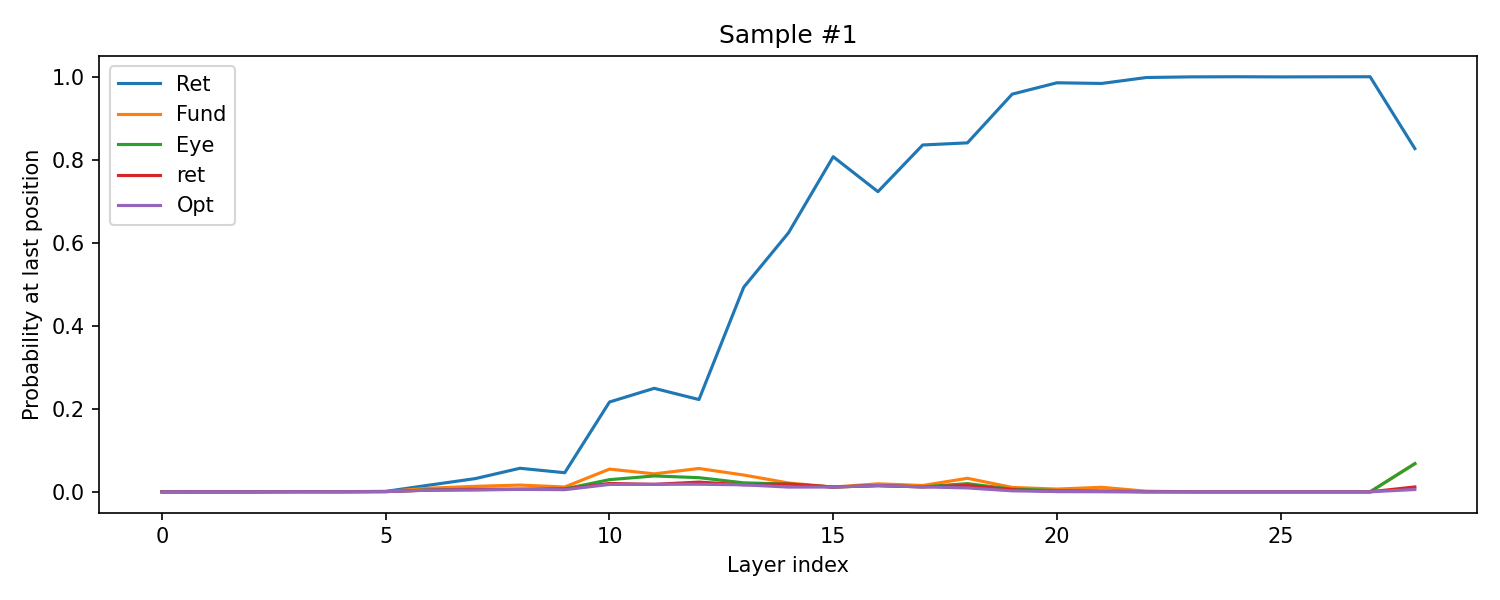

In [13]:
file_path = out_dir / f"token_trajectories_0001.png"
img = Image.open(file_path)
display(img)

Как можно видеть наибольшую вероятность имеет токен Ret, который является составной частью полного ответа, Retina. 

То есть модель Qwen2.5-VL действительно правильно понимает по фотографии, что перед ней изображение глазного дна. 

На первых слоях модель еще плохо понимает содержание входных данных, однако уже к середине сети Qwen 2.5-VL уверенно идентифицирует на изображении глазное дно и фокусируется на токене, соответствующем слову Retina. Последующие слои лишь усиливают эту уверенность, что подтверждает адекватность внутреннего представления модели о содержимом снимка.